In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import imageio


In [2]:
(x_train , y_train) , (_ , _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
x_train = x_train.astype('float32')/255.0

In [4]:
x_train = np.expand_dims(x_train, axis=3)


In [25]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * eps


class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = self.make_encoder()
        self.decoder = self.make_decoder()
        self.sampling = Sampling()

    def make_encoder(self):
        inputs = tf.keras.Input(shape=(28,28,1))
        x = tf.keras.layers.Conv2D(32, 3, strides=2, padding="same",
                                   activation=tf.keras.activations.leaky_relu)(inputs)
        x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same",
                                   activation=tf.keras.activations.leaky_relu)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(128, activation="relu")(x)
        z_mean = tf.keras.layers.Dense(self.latent_dim)(x)
        z_log_var = tf.keras.layers.Dense(self.latent_dim)(x)
        return tf.keras.Model(inputs, [z_mean, z_log_var], name="encoder")

    def make_decoder(self):
        inputs = tf.keras.Input(shape=(self.latent_dim,))
        x = tf.keras.layers.Dense(7*7*64, activation="relu")(inputs)
        x = tf.keras.layers.Reshape((7,7,64))(x)
        x = tf.keras.layers.UpSampling2D()(x)
        x = tf.keras.layers.Conv2D(32, 3, padding="same",
                                   activation=tf.keras.activations.leaky_relu)(x)
        x = tf.keras.layers.UpSampling2D()(x)
        outputs = tf.keras.layers.Conv2D(1, 3, padding="same",
                                         activation="sigmoid")(x)
        return tf.keras.Model(inputs, outputs, name="decoder")

    def train_step(self, x):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(x)
            z = self.sampling([z_mean, z_log_var])
            x_hat = self.decoder(z)

            recon_loss = tf.reduce_mean(
            tf.reduce_sum(
            tf.keras.losses.binary_crossentropy(x, x_hat),
            axis=(1, 2)
                )
            )


            kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(
                1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
                axis=1
                )
            )
            mae = tf.reduce_mean(tf.abs(x - x_hat))
            loss = recon_loss + kl_loss*10

        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        return {"loss": loss, "recon": recon_loss, "kl": kl_loss }



In [26]:
latent_dim = 64

# try changing the latent_dim size from 8-256 or 512 to see how well the model reconstructs the digits

vae = VAE(latent_dim=latent_dim)
vae.compile(optimizer=tf.keras.optimizers.Adam(1e-4))

history = vae.fit(x_train, epochs=50, batch_size=128)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - kl: 1.2911 - loss: 285.7366 - recon: 272.8259
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.1131 - loss: 215.4958 - recon: 204.3652
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.2162 - loss: 204.1559 - recon: 191.9941
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.3632 - loss: 201.5903 - recon: 187.9585
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.4732 - loss: 200.4408 - recon: 185.7090
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl: 1.5829 - loss: 199.3749 - recon: 183.5462
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.7289 - loss: 197.9659 - recon: 180.6766
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.8417 - loss: 196.6497 - recon: 178.2325
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.9057 - loss: 195.9094 - recon: 176.8520
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - kl: 1.9771 - loss: 195.4313 - recon: 175.660

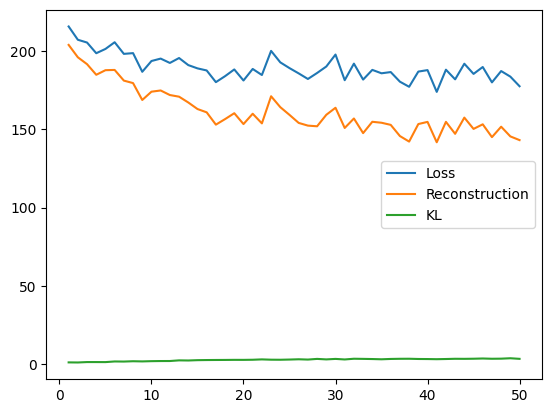

In [27]:
train_loss = history.history['loss']
train_recon = history.history['recon']
train_kl = history.history['kl']
epoch_list = [i for i in range(1 , 51)]

plt.plot(epoch_list, train_loss, label='Loss')
plt.plot(epoch_list, train_recon, label='Reconstruction')
plt.plot(epoch_list, train_kl, label='KL')
plt.legend()
plt.show()

In [16]:
# using this to test the decoder , i saw that even though the latent_dim was 64 , the digits werent good , many seemed hybrids of two diff numbers
mu , log_var = vae.encoder(x_train[:100])
mu = mu.numpy()
log_var = log_var.numpy()
sigma = np.exp(0.5 * log_var)
z_samples = mu + 0.5 * sigma * np.random.randn(latent_dim)


In [28]:
z_samples = tf.random.normal(shape=(100, latent_dim))



In [29]:
generated = vae.decoder(z_samples)

In [30]:
latent_output = vae.encoder(x_train)

In [31]:
real_z = latent_output[0][:1000]   # encoder output
sample_z = z_samples               # prior samples

combined_z = np.vstack([real_z, sample_z])


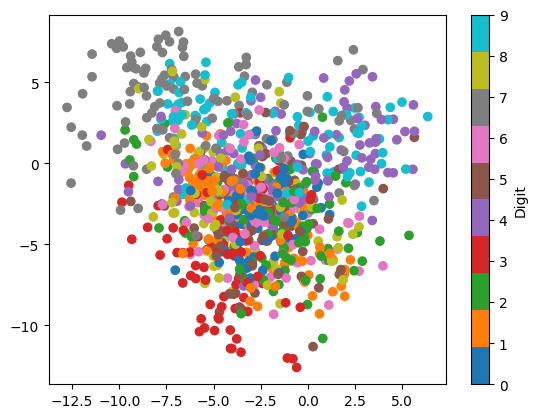

In [20]:
# only when latent_dims = 2
scatter=plt.scatter(real_z[:,0], real_z[:,1] , c=y_train[:1000] , cmap='tab10')
plt.colorbar(scatter , label='Digit')
plt.show()

In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedding = tsne.fit_transform(combined_z)


In [33]:
real_emb = embedding[:1000]
sample_emb = embedding[1000:]


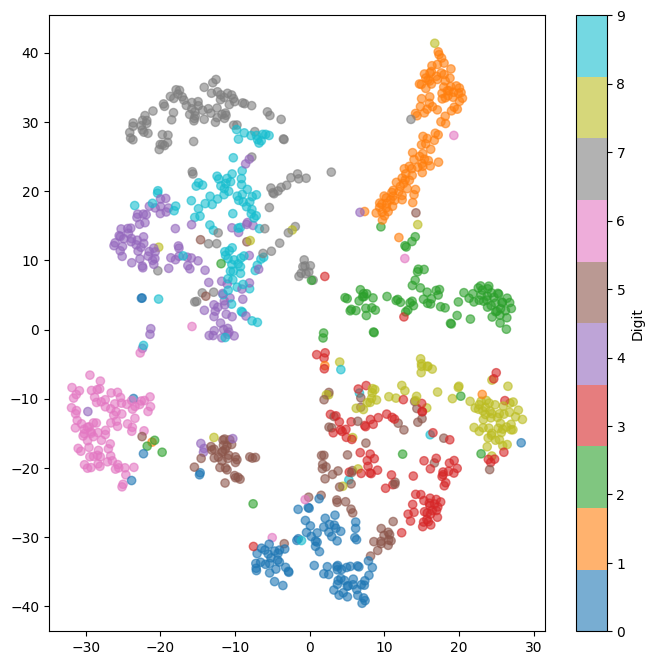

In [34]:
plt.figure(figsize=(8,8))

sc1 = plt.scatter(
    real_emb[:,0],
    real_emb[:,1],
    c=y_train[:1000],
    cmap='tab10',
    alpha=0.6,
    label="Encoded data"
)

plt.colorbar(sc1, label="Digit")


# indices = np.arange(len(sample_emb))

# sc2 = plt.scatter(
#     sample_emb[:,0],
#     sample_emb[:,1],
#     c=indices,
#     cmap='viridis',
#     marker='x',
#     s=80,
#     label="Samples"
# )

# plt.colorbar(sc2, label="Sample index")




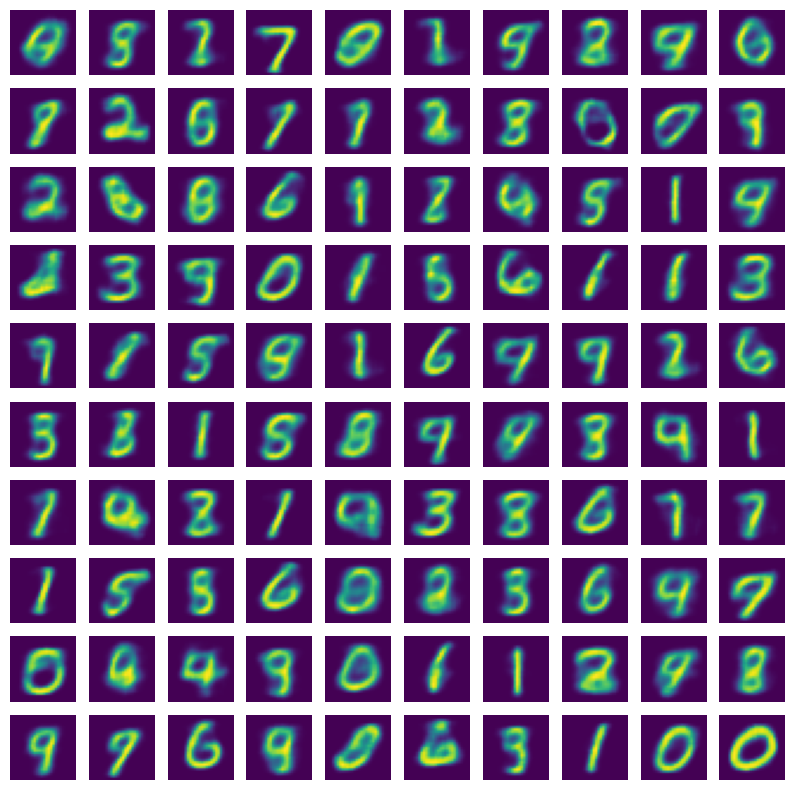

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(generated[i])
    plt.axis("off")
plt.show()


In [41]:
#  gifs

In [36]:
x_pair = x_train[:2]              # shape: (2, 28, 28, 1)

z_mean, _ = vae.encoder(x_pair, training=False)

z1 = z_mean[0].numpy()            # (32,)
z2 = z_mean[1].numpy()            # (32,)


In [37]:
print(z1.shape, z2.shape)



(64,) (64,)


In [38]:
def interpolate(z1, z2, steps=30):
    alphas = np.linspace(0, 1, steps)
    return np.stack([(1 - a) * z1 + a * z2 for a in alphas])



In [39]:
def latent_interpolation_gif(vae, x_train, steps=60, filename="interp.gif"):

    z_mean, _ = vae.encoder(x_train[5:7], training=False)

    z1 = z_mean[0].numpy()
    z2 = z_mean[1].numpy()

    assert z1.shape == (vae.latent_dim,)
    assert z2.shape == (vae.latent_dim,)

    frames = []
    alphas = np.linspace(0, 1, steps)

    for a in alphas:
        z = ((1 - a) * z1 + a * z2).reshape(1, -1)
        img = vae.decoder(z, training=False)[0]

        fig, ax = plt.subplots()
        ax.imshow(img.numpy().squeeze(), cmap="gray")
        ax.axis("off")

        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())
        frame = frame[:, :, :3]
        frames.append(frame)
        plt.close(fig)

    imageio.mimsave(filename, frames, fps=10)


In [40]:
latent_interpolation_gif(vae, x_train)


In [58]:
def grid_morph_gif(vae, grid_size=8, steps=20):
    frames = []

    z1 = np.random.randn(vae.latent_dim)
    z2 = np.random.randn(vae.latent_dim)

    for t in np.linspace(0, 1, steps):
        z = (1 - t) * z1 + t * z2
        imgs = vae.decoder(
            z[None, :] + np.random.randn(grid_size**2, vae.latent_dim) * 0.1,
            training=False
        )

        fig, ax = plt.subplots()
        ax.imshow(
            np.block([[imgs[i*grid_size + j].numpy().squeeze()
                      for j in range(grid_size)]
                      for i in range(grid_size)]),
            cmap="gray"
        )
        ax.axis("off")

        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())
        frame = frame[:, :, :3]   # drop alpha channel
        frames.append(frame)
        plt.close(fig)

    imageio.mimsave("grid_morph.gif", frames, fps=8)


In [59]:
grid_morph_gif(vae)

In [ ]:
def random_walk_gif(vae, steps=1000, step_size=2.5):
    z = np.random.randn(1, vae.latent_dim)
    frames = []

    for _ in range(steps):
        z += step_size * np.random.randn(*z.shape)
        img = vae.decoder(z, training=False)[0]

        fig, ax = plt.subplots()
        ax.imshow(img.numpy().squeeze(), cmap="gray")
        ax.axis("off")

        fig.canvas.draw()
        frame = np.asarray(fig.canvas.buffer_rgba())
        frame = frame[:, :, :3]
        frames.append(frame)
        plt.close(fig)

    imageio.mimsave("random_walk.gif", frames, fps=10)


In [ ]:
random_walk_gif(vae)